In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import distributions
from torch.nn.parameter import Parameter

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mass = -0.2
lam = 0.5
def target_action(x):
    A = torch.sum(lam/24.0* x**4 + (mass+2.0)*(x**2)/2.0 - x*torch.roll(x,dims=1,shifts=-1),dim=1 )
    return A

In [3]:
x = torch.randn(1,2)

In [4]:
x.requires_grad

False

In [5]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
    
    # this is the forward start from noise target
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x
    
    # this is backward from target to noise
    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp #+ self.C
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        #logp = self.prior.log_prob(z)
        x = self.g(z)
        return x
    

In [6]:
# this are functions returning nets
L=4 # the length of the lattice
nets = lambda: nn.Sequential(nn.Linear(L, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, L), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(L, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, L))
# the number of masks determines layers
mm = np.array([0]*int(L/2) + [1]*int(L/2))# mask 50% of the elements for realNVP
masks = torch.from_numpy(np.array([mm, 1-mm] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(L), torch.eye(L)) # a bit of an overkill for uncorrelated Normal
flow = RealNVP(nets, nett, masks, prior)

In [7]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(5001):   
    #with torch.no_grad():
    z = prior.sample((1000, 1)).squeeze()
    x = flow.g(z) # generate a sample
    loss = (flow.log_prob(x)+target_action(x)).mean() # KL divergence (or not?)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step() 
    if t % 500 == 0:
        #print(z.shape)
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = -1.544
iter 500: loss = -3.738
iter 1000: loss = -3.744
iter 1500: loss = -3.738
iter 2000: loss = -3.749
iter 2500: loss = -3.738
iter 3000: loss = -3.751
iter 3500: loss = -3.746
iter 4000: loss = -3.748
iter 4500: loss = -3.753
iter 5000: loss = -3.752


In [8]:
z = prior.sample((10, 1)).squeeze()
x = flow.g(z)

In [9]:
zz,j=flow.f(x)

In [10]:
print(zz.requires_grad,z.requires_grad)

True False


In [11]:
zz-z

tensor([[ 0.0000e+00,  2.3842e-07, -1.7881e-07,  0.0000e+00],
        [ 5.5879e-08,  0.0000e+00, -3.7253e-08, -5.9605e-08],
        [ 0.0000e+00, -1.1921e-07,  0.0000e+00,  2.9802e-08],
        [ 2.6822e-07, -1.4901e-08, -1.1921e-07,  0.0000e+00],
        [ 1.4901e-08, -1.1921e-07,  0.0000e+00,  0.0000e+00],
        [ 1.1548e-07, -2.3842e-07,  0.0000e+00, -3.1292e-07],
        [ 0.0000e+00,  1.4901e-07,  5.9605e-08,  1.0431e-07],
        [ 4.1910e-09,  3.5763e-07,  0.0000e+00,  5.9605e-08],
        [ 2.3842e-07, -1.1921e-07, -1.1921e-07,  0.0000e+00],
        [-1.1921e-07,  4.1723e-07,  2.3842e-07,  8.9407e-08]],
       grad_fn=<SubBackward0>)

In [12]:
diff = target_action(x)+flow.log_prob(x)
print(diff)

tensor([-3.9588, -3.7756, -3.8030, -3.4973, -3.7450, -3.6834, -3.7837, -3.8325,
        -3.7390, -3.8021], grad_fn=<AddBackward0>)


In [13]:
print(diff - diff.mean())

tensor([-0.1968, -0.0135, -0.0410,  0.2648,  0.0171,  0.0786, -0.0216, -0.0705,
         0.0230, -0.0401], grad_fn=<SubBackward0>)


In [14]:
z = prior.sample((2000, 1)).squeeze()
xz = flow.g(z).detach()
diff = target_action(xz)+flow.log_prob(xz)
diff.std()

tensor(0.0983, grad_fn=<StdBackward0>)

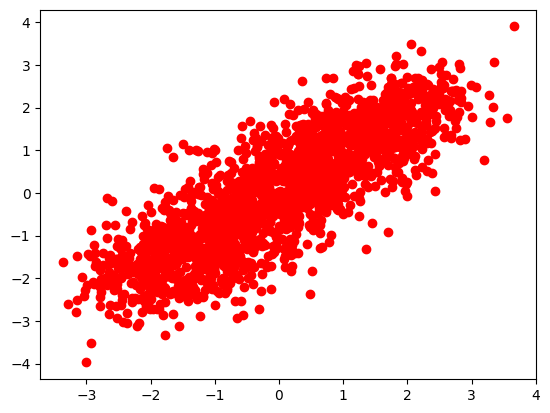

In [15]:
x = flow.sample(2000).detach().numpy()
plt.scatter(x[:, 0,0], x[:, 0,1], c='r')